# Make a custom database :
**The goal is to build a custom dataset to face recognition from scratch.**
```bash
custom_dataset
├── firstname_lastname
│   ├── File firstname_lastname0.jpeg
│   └── File firstname_lastname1.jpeg
├── firstname_lastname
│   ├── File firstname_lastname0.jpeg
│   └── File firstname_lastname1.jpeg
├── ...
│   ├── File firstname_lastname0.jpeg
│   └── File firstname_lastname1.jpeg
```
### How to proceed step by step
1. Take picture with your phone
2. Rename them
3. Crop in the faces and aligne them automatically
4. compresse the picture
5. Zip the folder and upload it to GitHub

Once it is hosted on GitHub,  download it with `!wget url` and `!unzip filename`.


> *The goal is that the database is accessible to everyone **without** any Google Drive credentials (partner and classmates)*

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
!unzip models.zip
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/figures.zip
!unzip figures.zip
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/data.zip
!unzip data.zip

In [98]:
import os
import numpy as np
import cv2
import dlib
import time
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


variables de travail ✍

In [4]:
drive_dataset       = os.path.join("/content", "drive", "MyDrive", "Colab Notebooks", "DeepLearningAtelier-E3", "TP7", "personal_dataset")
luca_gambier        = os.path.join("/content", "drive", "MyDrive", "Colab Notebooks", "DeepLearningAtelier-E3", "TP7", "luca_gambier")
luca_gambier_178    = os.path.join("/content", "drive", "MyDrive", "Colab Notebooks", "DeepLearningAtelier-E3", "TP7", "luca_gambier", "luca_gambier_178.jpg")

#### provided functions : 

In [79]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    """
    Retourne une liste de path des images, de tous les rep et ss rep.
    """
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename) #.replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

In [16]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')
#   About ==== dlib.get_frontal_face_detector() ====
#   This example program shows how to find frontal human faces in an image.  In
#   particular, it shows how you can take a list of images from the command
#   line and display each on the screen with red boxes overlaid on each human
#   face.

def face_locations(image, model="hog"):
    """
    Retourne une liste contenant pour chaque images un cadre autour du visage
    @param: image est un tableau np
    """
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [17]:
def extract_faces(image, model="hog") -> np.array([]):
    """
    Retourne l'image du visage zoomé et centré
    @param: image est un tableau np
    @return: faces : List de tableau Numpy de taille 128*128
    """
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [18]:
def show_grid(faces : list, figsize=(12,3)):
    """
    Fait un plot de tous les visages de faces
    @param: faces c'est un tableau de visage croppé sous la forme de [ndarray]
    """

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))
    
    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

In [19]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [20]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [21]:
#@title ######TEMPLATE
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [22]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

In [24]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

In [83]:
#@title ##### Extract faces and labels
def img_to_numpy(list_path, show : bool = False, get_info : bool = False, save_values : bool = True, debug : bool = False) -> tuple :
    """
    This function allow to convert images to NumPy arrays as a vector of [label, faces].
    1. extract the face to an image
    2. get the label from the path
    3. make a vector with vstack : [label, faces]
    4. ask to save the vector on Google Drive
    :param list_path: Une list de os.path content les images à analyser
    :param show: display images
    :param get_info : print information on the output
    :param debug: print information to help on the debug
    :param save_values: store the output on Google Drive
    :return list_errors: The list which contain the errors due to a missing detection of the face
    """

    list_errors = []

    # data_structure est init en (0,2) car np.vstack a doit stack des array de meme taille <!>
    # data_structure = np.array([]) ne marche pas
    data_structure = np.empty((0, 2), dtype=object)

    for i, img_path in enumerate(list_path):
        try :
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            face = extract_faces(image, "cnn")    # ne marche pas avec 'hog' si le visage n'est pas bien visible

            if show : plt.imshow(face[i])

            # get the label: split on '/'
            label = img_path.split('/')[-2]

            face = np.array(face).reshape(128, 128, 3)

            data_structure = np.vstack((data_structure, np.array([label, np.array(face)]))) # cast de face (list) to np.ndarray

        except Exception as e:
            print(e)


    # print en cas d'images non traitée(s)
    if len(list_errors) > 0 :
        print("<- Error -> \t :")
        print("{} images non traitées !!!\n \n".format(len(list_errors)))

    return list_errors, data_structure

#### test

In [101]:
assert os.path.exists(luca_gambier), "the base path is wrong"
list_path = list_images(luca_gambier)
print(len(list_path))
print(list_path)

for i, path in enumerate(list_path) : 
    # print(f"try {i}")
    try : 
        assert os.path.exists(path), "the path is wrong"
        assert os.path.isfile(path), "the file is wrong"
        
    except Exception as e : 
        print(e)

print("check done") 

6
['/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_180.jpg', '/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_181.jpg', '/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_182.jpg', '/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_184.jpg', '/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_178.jpg', '/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3/TP7/luca_gambier/luca_gambier_179.jpg']
check done


In [90]:
labels_faces = img_to_numpy(list_path)[1]

<ipython-input-83-5e08f94ef321>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_structure = np.vstack((data_structure, np.array([label, np.array(face)]))) # cast de face (list) to np.ndarray


In [91]:
labels  = np.array([i[0] for i in labels_faces])
faces   = np.array([i[1] for i in labels_faces])

In [100]:
len(faces)

6

In [102]:
print(labels)

['luca_gambier' 'luca_gambier' 'luca_gambier' 'luca_gambier'
 'luca_gambier' 'luca_gambier']


aligned faces

In [103]:
landmarks = face_landmarks(list(faces))

In [109]:
aligned = align_faces(faces, landmarks)

In [110]:
print(len(aligned))


6


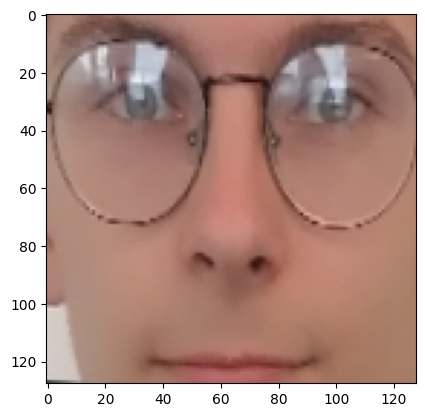

In [114]:
plt.imshow(aligned[-1])